In [129]:
%load_ext autoreload
%autoreload 2

import RIS_gravity_inversion.inversion as inv 
import RIS_gravity_inversion.utils as utils

import numpy as np
import pandas as pd
# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*1)/10000)
notify = Audio(wave, rate=10000, autoplay=True)

import os 
os.getcwd()
%load_ext snakeviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


#  Setup inversion and layers

inversion region is 300 x 300 km
filtering and resampling ice from 1000m to 10000m
filtering and resampling water from 1000m to 10000m
filtering and resampling bathymetry from 1000m to 10000m
ice: 4900 points, elevations:3256m to 0m
water: 4900 points, elevations:3231m to -946m
bathymetry: 4900 points, elevations:3231m to -1081m
gravity: 897 points
gravity avg. elevation: 1000
bathymetry control points:10475932


,x,y,Gobs,z
0,-125000.0,-925000.0,-4.311324,1000.0
1,-115000.0,-925000.0,-7.410319,1000.0
2,-105000.0,-925000.0,-8.355430,1000.0
3,-95000.0,-925000.0,-5.209347,1000.0
4,-85000.0,-925000.0,-3.568311,1000.0
...,...,...,...,...
892,125000.0,-1215000.0,18.106532,1000.0
893,135000.0,-1215000.0,16.453323,1000.0
894,145000.0,-1215000.0,14.275695,1000.0
895,155000.0,-1215000.0,3.847872,1000.0


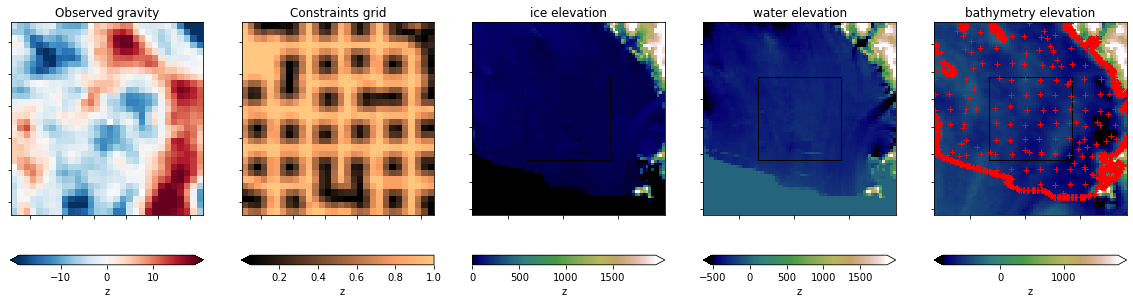

In [219]:
# starting inversion region is 1,000km x 1,000km, choose whether to zoom in, shift the 
# region to the North or West, or change the width of the buffer zone. 
inv_reg, buffer_reg = inv.setup_region(
    zoom = 350e3,
    n_shift = 150e3,
    w_shift = 100e3,
    buffer = 200e3,
    )

returned = inv.import_layers(
    layers_list = [
        'ice',
        'water',
        'bathymetry',
        # 'basement',
        # 'moho',
        ], 
    spacing_list = [
        10e3,
        10e3,
        10e3,
        # 10e3,
        # 20e3,
        ], 
    rho_list = [
        920, #890 to 917 from Muto et al. 2013
        1030, #from Muto et al. 2013
        2300,
        # 2670,
        # 3300,
        ],
    fname_list = [
        # SURFACE 
            'inversion_layers/bedmachine/BedMachine_surface_filled.nc',
        # ICEBASE
            'inversion_layers/bedmachine/BedMachine_icebase_filled.nc',
        # BED/BATHYMETRY
            # 'bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc',
            # 'bathymetry_data/bedmap2_bed_regional.nc',
            'inversion_layers/bedmachine/BedMachine_bed.nc',
        # BASEMENT
            # 'inversion_layers/ANTASed_mag_basement_filled.nc',
            # 'inversion_layers/RE_basement_BedMachinebed_filled.nc',
            # 'inversion_layers/lindeque_basement.nc',
        # MOHO
            # 'inversion_layers/An_moho_filt.nc',
            # 'inversion_layers/Shen_moho.nc',
            # 'inversion_layers/Pappa_moho.nc',
        ],
    grav_spacing = 10e3, 
    active_layer='bathymetry',
    buffer_region = buffer_reg,
    inversion_region = inv_reg,

    # Choose between grid and csv, similar comp. times
    # grav_file='gravity_data/rosetta_eq_source_up_continued_Gobs.nc',
    grav_file='gravity_data/rosetta_eq_source_up_continued.csv',

    constraints=True,
    constraints_file='constraints_grid/constraints_grid.nc',
    constraints_points='bathymetry_data/bedmachine_RIGGS.csv',
    
    plot=True,
    plot_region=buffer_reg
    )
layers, grav, constraints_grid, constraints_df, constraints_RIS_df = returned
grav

# Make prism layers

bathymetry top: -500m and bottom: -1081m
water top: -173m andbottom: -500m
ice top: 111m andbottom: -173m


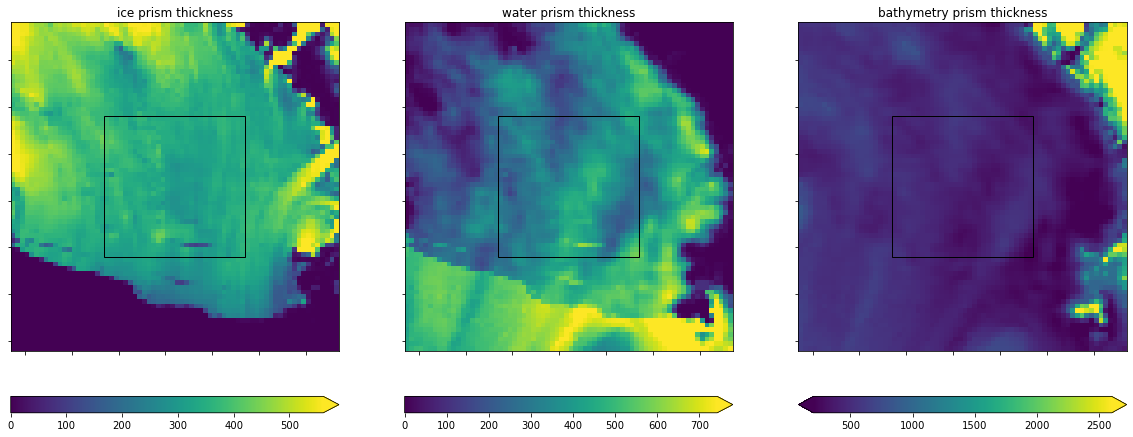

In [220]:
inv.grids_to_prism_layers( 
    layers, 
    plot=True, 
    # plot_region=inv_reg,
    plot_type='2D', 
    buffer_region = buffer_reg,
    inversion_region = inv_reg,
    ) 

# Forward gravity

using supplied DataFrame for observation points
finished ice layer
finished water layer
finished bathymetry layer


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total
count,897.000000,8.970000e+02,897.000000,897.0,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02
mean,20089.186176,-1.069799e+06,0.000000,1000.0,-2.376397e-16,-3.485382e-16,4.689424e-15,4.467627e-15
std,86583.161311,8.658024e+04,8.653377,0.0,1.078401e+00,3.318656e+00,6.516622e+00,3.530390e+00
min,-125000.000000,-1.215000e+06,-23.628281,1000.0,-7.817536e+00,-7.329680e+00,-2.362247e+01,-1.380687e+01
25%,-55000.000000,-1.145000e+06,-5.463294,1000.0,-5.978962e-01,-2.623727e+00,-4.643964e+00,-2.377639e+00
50%,15000.000000,-1.065000e+06,-1.350063,1000.0,8.099132e-02,-4.172742e-01,6.945899e-01,1.918455e-01
75%,95000.000000,-9.950000e+05,5.283131,1000.0,6.106782e-01,2.329942e+00,4.988942e+00,2.447992e+00
max,165000.000000,-9.250000e+05,29.364606,1000.0,3.434616e+00,1.118564e+01,1.526490e+01,8.775249e+00


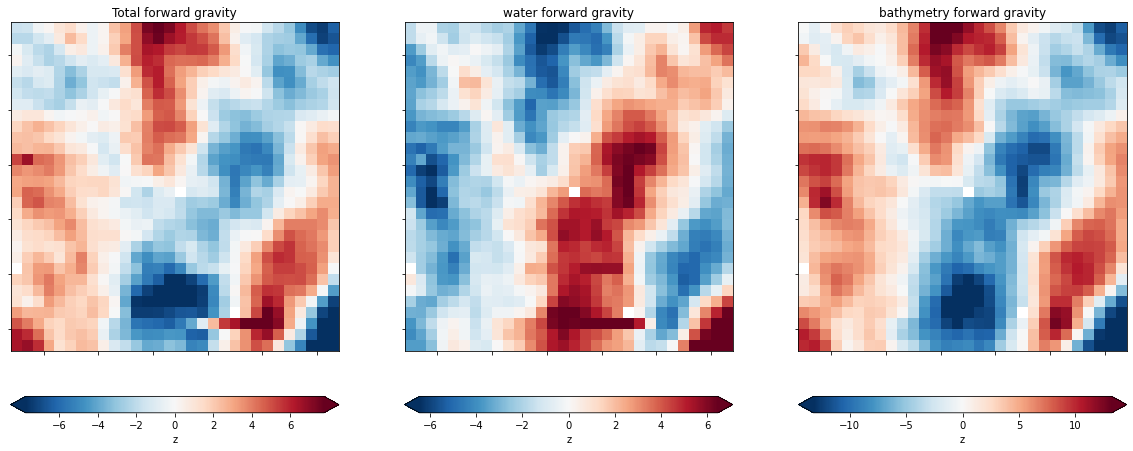

In [221]:
df_forward = inv.forward_grav_layers(
    layers, 
    grav,  
    plot=True,
    grav_spacing=grav_spacing,
    inversion_region = inv_reg,
    exclude_layers=['ice'],
    )
df_forward.describe()

# Anomalies

Root mean squared residual: 4.05mGal


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,grav_corrected,misfit,reg,res
count,897.000000,8.970000e+02,897.000000,897.0,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02,897.000000,897.000000
mean,20089.186176,-1.069799e+06,0.000000,1000.0,-2.376397e-16,-3.485382e-16,4.689424e-15,4.467627e-15,1.901118e-16,-4.309200e-15,0.049911,-0.049911
std,86583.161311,8.658024e+04,8.653377,0.0,1.078401e+00,3.318656e+00,6.516622e+00,3.530390e+00,8.829127e+00,7.587490e+00,5.374512,4.056149
min,-125000.000000,-1.215000e+06,-23.628281,1000.0,-7.817536e+00,-7.329680e+00,-2.362247e+01,-1.380687e+01,-2.422394e+01,-2.083793e+01,-9.888793,-12.628231
25%,-55000.000000,-1.145000e+06,-5.463294,1000.0,-5.978962e-01,-2.623727e+00,-4.643964e+00,-2.377639e+00,-5.583090e+00,-4.796257e+00,-3.443011,-2.551363
50%,15000.000000,-1.065000e+06,-1.350063,1000.0,8.099132e-02,-4.172742e-01,6.945899e-01,1.918455e-01,-1.431320e+00,-7.673191e-01,-1.100106,-0.012301
75%,95000.000000,-9.950000e+05,5.283131,1000.0,6.106782e-01,2.329942e+00,4.988942e+00,2.447992e+00,5.428009e+00,4.514150e+00,4.314573,2.360519
max,165000.000000,-9.250000e+05,29.364606,1000.0,3.434616e+00,1.118564e+01,1.526490e+01,8.775249e+00,2.998205e+01,2.406473e+01,13.938244,12.466694


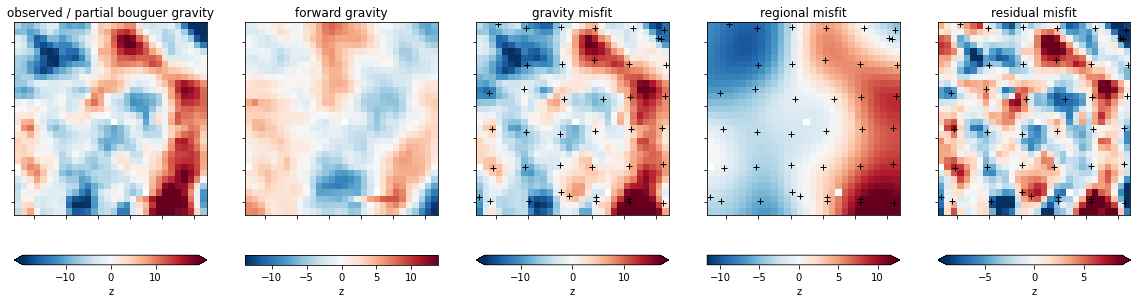

In [222]:
filter='g200e3'
df_anomalies = inv.anomalies(
        layers, 
        df_forward,
        grav_spacing, 
        'filter', 
        filter=filter,
        inversion_region=inv_reg,
        corrections=['ice'], 
        plot=True, 
        plot_constraints=True,
        constraints2plot=constraints_RIS_df,
        )

df_anomalies.describe()

Root mean squared residual: 2.9mGal


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,grav_corrected,misfit,reg,res
count,897.000000,8.970000e+02,897.000000,897.0,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02,897.000000,897.000000
mean,20089.186176,-1.069799e+06,0.000000,1000.0,-2.376397e-16,-3.485382e-16,4.689424e-15,4.467627e-15,1.901118e-16,-4.309200e-15,-0.017059,0.017059
std,86583.161311,8.658024e+04,8.653377,0.0,1.078401e+00,3.318656e+00,6.516622e+00,3.530390e+00,8.829127e+00,7.587490e+00,7.012721,2.906389
min,-125000.000000,-1.215000e+06,-23.628281,1000.0,-7.817536e+00,-7.329680e+00,-2.362247e+01,-1.380687e+01,-2.422394e+01,-2.083793e+01,-14.642547,-7.603853
25%,-55000.000000,-1.145000e+06,-5.463294,1000.0,-5.978962e-01,-2.623727e+00,-4.643964e+00,-2.377639e+00,-5.583090e+00,-4.796257e+00,-4.268890,-1.957725
50%,15000.000000,-1.065000e+06,-1.350063,1000.0,8.099132e-02,-4.172742e-01,6.945899e-01,1.918455e-01,-1.431320e+00,-7.673191e-01,-0.982379,-0.031986
75%,95000.000000,-9.950000e+05,5.283131,1000.0,6.106782e-01,2.329942e+00,4.988942e+00,2.447992e+00,5.428009e+00,4.514150e+00,4.367397,2.073183
max,165000.000000,-9.250000e+05,29.364606,1000.0,3.434616e+00,1.118564e+01,1.526490e+01,8.775249e+00,2.998205e+01,2.406473e+01,28.479602,8.257996


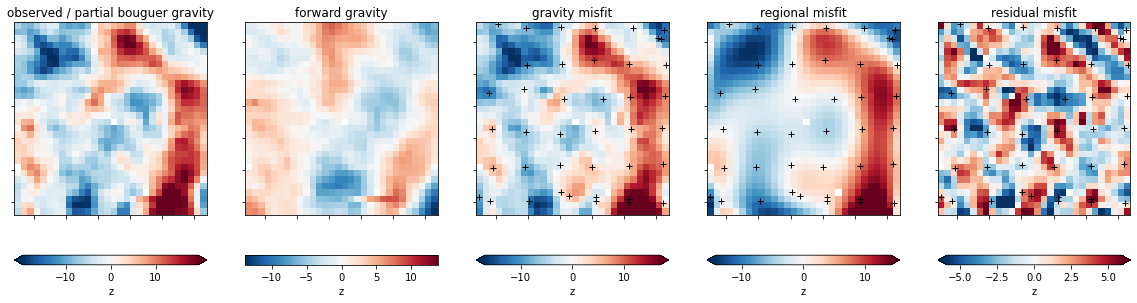

In [223]:
trend=8
df_anomalies = inv.anomalies(
        layers, 
        df_forward,
        grav_spacing, 
        'trend', 
        trend=trend,
        inversion_region=inv_reg,
        corrections=['ice'], 
        plot=True, 
        plot_constraints=True,
        constraints2plot=constraints_RIS_df,
        )
df_anomalies.describe()

Root mean squared residual: 3.7mGal


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,grav_corrected,misfit,reg,res
count,897.000000,8.970000e+02,897.000000,897.0,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02,8.970000e+02,897.000000,897.000000
mean,20089.186176,-1.069799e+06,0.000000,1000.0,-2.376397e-16,-3.485382e-16,4.689424e-15,4.467627e-15,1.901118e-16,-4.309200e-15,0.019235,-0.019235
std,86583.161311,8.658024e+04,8.653377,0.0,1.078401e+00,3.318656e+00,6.516622e+00,3.530390e+00,8.829127e+00,7.587490e+00,7.346060,3.698806
min,-125000.000000,-1.215000e+06,-23.628281,1000.0,-7.817536e+00,-7.329680e+00,-2.362247e+01,-1.380687e+01,-2.422394e+01,-2.083793e+01,-17.843061,-11.061031
25%,-55000.000000,-1.145000e+06,-5.463294,1000.0,-5.978962e-01,-2.623727e+00,-4.643964e+00,-2.377639e+00,-5.583090e+00,-4.796257e+00,-5.161870,-2.280194
50%,15000.000000,-1.065000e+06,-1.350063,1000.0,8.099132e-02,-4.172742e-01,6.945899e-01,1.918455e-01,-1.431320e+00,-7.673191e-01,0.279320,0.075580
75%,95000.000000,-9.950000e+05,5.283131,1000.0,6.106782e-01,2.329942e+00,4.988942e+00,2.447992e+00,5.428009e+00,4.514150e+00,5.213266,2.220658
max,165000.000000,-9.250000e+05,29.364606,1000.0,3.434616e+00,1.118564e+01,1.526490e+01,8.775249e+00,2.998205e+01,2.406473e+01,24.226156,12.564208


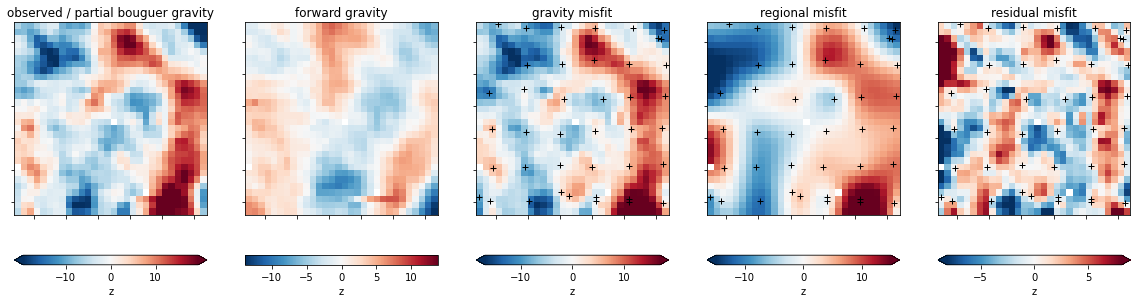

In [224]:
df_anomalies = inv.anomalies(
        layers, 
        df_forward, 
        grav_spacing, 
        'constraints', 
        constraints=constraints_df,
        constraints2plot=constraints_RIS_df,
        inversion_region=inv_reg,
        corrections=['ice'], 
        plot=True, 
        plot_constraints=True,
        )
df_anomalies.describe()

# Geo inversion

In [226]:
# %%snakeviz --new-tab
regional_method='constraints'

iter_corrections, df_inversion = inv.geo_inversion(
    active_layer='bathymetry',
    layers=layers, 
    input_grav=df_anomalies, 
    regional_method = regional_method,
    Max_Iterations=3,
    deriv_type='prisms',
    max_layer_change_per_iter=100,

    apply_constraints = False,
    constraints_grid=constraints_grid,
    exclude_layers=['ice'],

    # filter=filter, 
    # trend=trend,
    constraints=constraints_df,

    inversion_region = inv_reg,
    buffer_region=buffer_reg,
    grav_spacing = grav_spacing,
    ) 
# full size, just ROSETTA, 5km res, Ice/Water/Bathy, annulus, 5its, 5th trend,: 18m 3s
# full size, just ROSETTA, 5km res, Ice/Water/Bathy, annulus, 5its, 400km filter,: 19m 35s

# 07/27/22, full size, just ROSETTA, 20km res, Ice/Water/Bathy, annulus, 3its, constraints off
# 200km filter. 200km buffer,: 14mins
# 07/27/22, full size, just ROSETTA, 20km res, Ice/Water/Bathy, prisms, 3its, constraints off
# res from 200km filter. 200km buffer,: 2 mins

# 07/28/22, full size, just ROSETTA, 10km res, Ice/Water/Bathy, prisms, 3its, constraints off
# res from constraints. 200km buffer, mins
notify

##################################
iteration 1
initial RMS residual = 3.7mGal
RMS layer correction 18.39m
constraints not applied
calculating updated forward gravity
updating the misfits
Root mean squared residual: 1.82mGal
##################################
iteration 2
initial RMS residual = 1.82mGal
RMS layer correction 9.32m
constraints not applied
calculating updated forward gravity
updating the misfits
Root mean squared residual: 0.85mGal
##################################
iteration 3
initial RMS residual = 0.85mGal
RMS layer correction 4.38m
constraints not applied
calculating updated forward gravity
updating the misfits
Root mean squared residual: 0.42mGal
Inversion terminated after 3 iterations with least-squares norm=0 because maximum number of iterations (3) reached


In [229]:
df_inversion

,x,y,Gobs,z,ice_forward_grav,water_forward_grav,bathymetry_forward_grav,forward_total,grav_corrected,misfit,...,iter_2_initial_misfit,iter_2_bathymetry_forward_grav,iter_2_water_forward_grav,iter_2_forward_total,iter_2_final_misfit,iter_3_initial_misfit,iter_3_bathymetry_forward_grav,iter_3_water_forward_grav,iter_3_forward_total,iter_3_final_misfit
0,-125000.0,-925000.0,-4.311324,1000.0,1.611740,-1.628143,-0.027975,-1.656118,-5.923064,-4.266946,...,-0.956716,3.553909,-3.272064,0.281845,-0.480136,-0.480136,3.129312,-3.081544,0.047768,-0.263339
1,-115000.0,-925000.0,-7.410319,1000.0,0.869566,-0.340678,-1.246426,-1.587104,-8.279885,-6.692781,...,0.111831,-2.391526,0.130623,-2.260903,0.013879,0.013879,-2.322429,0.100027,-2.222402,-0.028086
2,-105000.0,-925000.0,-8.355430,1000.0,0.334178,-0.390991,0.062948,-0.328044,-8.689608,-8.361564,...,0.818867,-4.124138,1.438399,-2.685739,0.344236,0.344236,-3.724288,1.259614,-2.464674,0.133359
3,-95000.0,-925000.0,-5.209347,1000.0,1.055108,-2.054826,2.193576,0.138750,-6.264455,-6.403205,...,-0.166536,2.989591,-2.460814,0.528777,-0.082399,-0.082399,2.962600,-2.448513,0.514087,-0.044594
4,-85000.0,-925000.0,-3.568311,1000.0,0.719464,-2.130297,3.114392,0.984095,-4.287775,-5.271870,...,-0.867136,7.478203,-4.136771,3.341432,-0.384582,-0.384582,7.149149,-3.989246,3.159903,-0.168984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,125000.0,-1215000.0,18.106532,1000.0,-0.431748,3.247480,-6.325617,-3.078137,18.538280,21.616417,...,0.692231,-7.440851,3.689089,-3.751762,0.422058,0.422058,-6.962979,3.475153,-3.487827,0.298776
893,135000.0,-1215000.0,16.453323,1000.0,-1.299090,6.464291,-11.593294,-5.129003,17.752413,22.881416,...,-1.670675,-2.027672,2.122829,0.095157,-0.676112,-0.676112,-2.648073,2.400728,-0.247345,-0.231510
894,145000.0,-1215000.0,14.275695,1000.0,-0.256366,7.430668,-16.067770,-8.637102,14.532061,23.169163,...,-3.311275,4.178685,-1.693793,2.484891,-1.479905,-1.479905,2.756303,-1.056747,1.699556,-0.654952
895,155000.0,-1215000.0,3.847872,1000.0,0.043696,9.451228,-21.257685,-11.806457,3.804176,15.610633,...,-3.707123,-4.032313,1.679884,-2.352428,-1.740073,-1.740073,-5.713716,2.432926,-3.280790,-0.850120


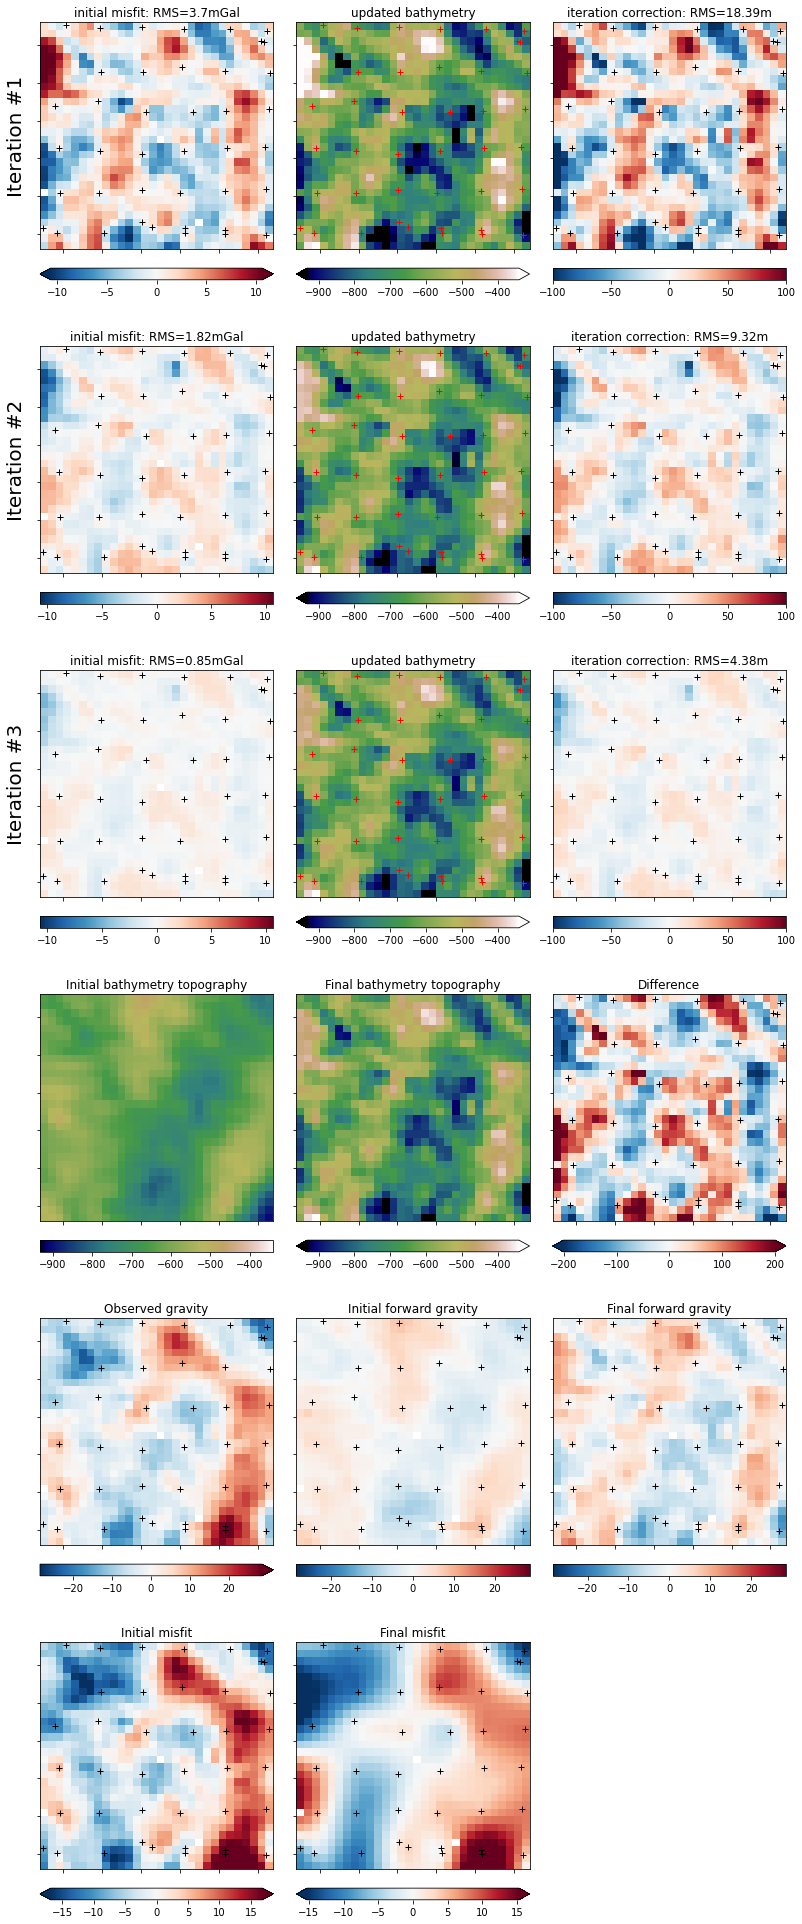

In [234]:
inv.plot_inversion_results(
    df_inversion,
    'bathymetry',
    grav_spacing,
    'epsg:3031',
    layers,
    iter_corrections,
    inversion_region = inv_reg,
    # plot_region = buffer_reg,
    plot_constraints = True,
    constraints = constraints_RIS_df,
)

# Density inversion

In [12]:
# density_inversion(density_layer='bathymetry', plot=True) #10mins, 200km zoom/5k, 3.5mins 400km zoom/5k (113x113 prisms, 33x33 grav)
# notify